# Dataset feature distributions 

In [42]:
import ast
import os
from pathlib import Path
from typing import List, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
CSV_PATH = os.getenv("CSV_PATH", "data/en_ewt-ud-train_sentences.csv")

EXCLUDE_SENT_START = False 
MAX_INDEX = 10
MAX_LENGTH = 10
MIN_HEAD_DIST, MAX_HEAD_DIST = -6, 6
MAX_ariety = 6

TOPK_POS = 14
TOPK_REL = 12

SAVE_FIG = False
FIG_PATH = Path("dataset_feature_distributions.png")

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)


In [44]:
def _to_list(x):
    """Parse list-like cells robustly (accept Python-lists serialized as strings)."""
    if isinstance(x, str):
        x = x.strip()
        if x.startswith('[') and x.endswith(']'):
            try:
                return ast.literal_eval(x)
            except Exception:
                return [x]
        return [x]
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    return [x]


def _pick_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    """Return the first column from candidates that exists in df, else None."""
    for c in candidates:
        if c in df.columns:
            return c
    return None

In [45]:
def expand_to_tokens(csv_path: str, exclude_sent_start: bool = False) -> pd.DataFrame:
    """Expand sentence-level CSV rows into a token-level DataFrame.

    Expected columns (flexible names):
      - sentence_id
      - tokens (list of surface forms)
      - optional: pos, index/position, head_dist, relation_type, ariety (all list-like)

    Missing optional columns are filled with NaN.
    """
    df_all = pd.read_csv(csv_path)

    sid_col = _pick_col(df_all, ["sentence_id", "sent_id", "sid", "SentenceID"])
    tok_col = _pick_col(df_all, ["tokens", "Tokens", "words", "Words"])
    pos_col = _pick_col(df_all, ["pos", "upos", "POS", "Pos"])
    idx_col = _pick_col(df_all, ["index", "token_index", "position", "positions", "idx"])
    hd_col  = _pick_col(df_all, ["head_dist", "head_distance", "dep_head_dist", "gov_dist"])
    rel_col = _pick_col(df_all, ["relation_type", "deprel", "dep_rel", "relation", "rel"])
    ar_col  = _pick_col(df_all, ["ariety", "head_ariety", "dep_ariety"])

    if sid_col is None or tok_col is None:
        raise ValueError(
            f"CSV must contain sentence id + tokens. Found columns: {list(df_all.columns)[:25]}"
            f"Tried sentence_id candidates: {['sentence_id','sent_id','sid','SentenceID']}\n"
            f"Tried tokens candidates: {['tokens','Tokens','words','Words']}"
        )

    df_all[tok_col] = df_all[tok_col].apply(_to_list)
    if pos_col is not None: df_all[pos_col] = df_all[pos_col].apply(_to_list)
    if idx_col is not None: df_all[idx_col] = df_all[idx_col].apply(_to_list)
    if hd_col  is not None: df_all[hd_col]  = df_all[hd_col].apply(_to_list)
    if rel_col is not None: df_all[rel_col] = df_all[rel_col].apply(_to_list)
    if ar_col  is not None: df_all[ar_col]  = df_all[ar_col].apply(_to_list)

    rows = []
    for _, r in df_all.iterrows():
        sid = r[sid_col]
        toks = r[tok_col]

        posl = r[pos_col] if pos_col is not None else None
        idxl = r[idx_col] if idx_col is not None else None
        hdl  = r[hd_col]  if hd_col  is not None else None
        rell = r[rel_col] if rel_col is not None else None
        arl  = r[ar_col]  if ar_col  is not None else None

        L = len(toks)
        for lst in (posl, idxl, hdl, rell, arl):
            if lst is not None:
                L = min(L, len(lst))

        for wid in range(L):
            if exclude_sent_start and wid == 0:
                continue

            token = toks[wid]
            pos   = str(posl[wid]).upper() if (posl is not None and posl[wid] is not None) else np.nan

            index = (idxl[wid] if idxl is not None else (wid + 1))

            hd    = (hdl[wid]  if hdl  is not None else np.nan)
            rel   = (rell[wid] if rell is not None else np.nan)
            ariety = (arl[wid]  if arl  is not None else np.nan)

            length = len(str(token))

            rows.append((sid, wid, token, pos, index, length, hd, rel, ariety))

    tok_df = pd.DataFrame(
        rows,
        columns=[
            "sentence_id", "word_id", "word", "pos",
            "index", "length", "head_dist", "relation_type", "ariety",
        ],
    )

    tok_df["word_norm"] = tok_df["word"].astype(str).str.casefold()
    return tok_df


In [46]:
print(f"Reading: {CSV_PATH}")
df_tokens = expand_to_tokens(CSV_PATH, exclude_sent_start=EXCLUDE_SENT_START)
print(f"Expanded to {len(df_tokens):,} token rows.")

for col in ["index", "length", "head_dist", "ariety"]:
    if col in df_tokens.columns:
        df_tokens[col] = pd.to_numeric(df_tokens[col], errors="coerce")


Reading: data/en_ewt-ud-train_sentences.csv
Expanded to 194,916 token rows.


In [47]:
index_counts = (
    df_tokens[df_tokens["index"].between(1, MAX_INDEX)]["index"]
    .value_counts(sort=False)
    .reindex(range(1, MAX_INDEX + 1), fill_value=0)
)

length_counts = (
    df_tokens[df_tokens["length"].between(1, MAX_LENGTH)]["length"]
    .value_counts(sort=False)
    .reindex(range(1, MAX_LENGTH + 1), fill_value=0)
)

head_dist_counts = None
if df_tokens["head_dist"].notna().any():
    bins = list(range(MIN_HEAD_DIST, MAX_HEAD_DIST + 1))
    head_dist_counts = (
        df_tokens[df_tokens["head_dist"].between(MIN_HEAD_DIST, MAX_HEAD_DIST)]["head_dist"]
        .round()
        .astype(int)
        .value_counts(sort=False)
        .reindex(bins, fill_value=0)
    )

ariety_counts = None
if df_tokens["ariety"].notna().any():
    ar_bins = list(range(0, MAX_ariety + 1))
    ariety_counts = (
        df_tokens[df_tokens["ariety"].between(0, MAX_ariety)]["ariety"]
        .round()
        .astype(int)
        .value_counts(sort=False)
        .reindex(ar_bins, fill_value=0)
    )

pos_counts = df_tokens["pos"].dropna().value_counts().head(TOPK_POS)
rel_counts = df_tokens["relation_type"].dropna().value_counts().head(TOPK_REL)

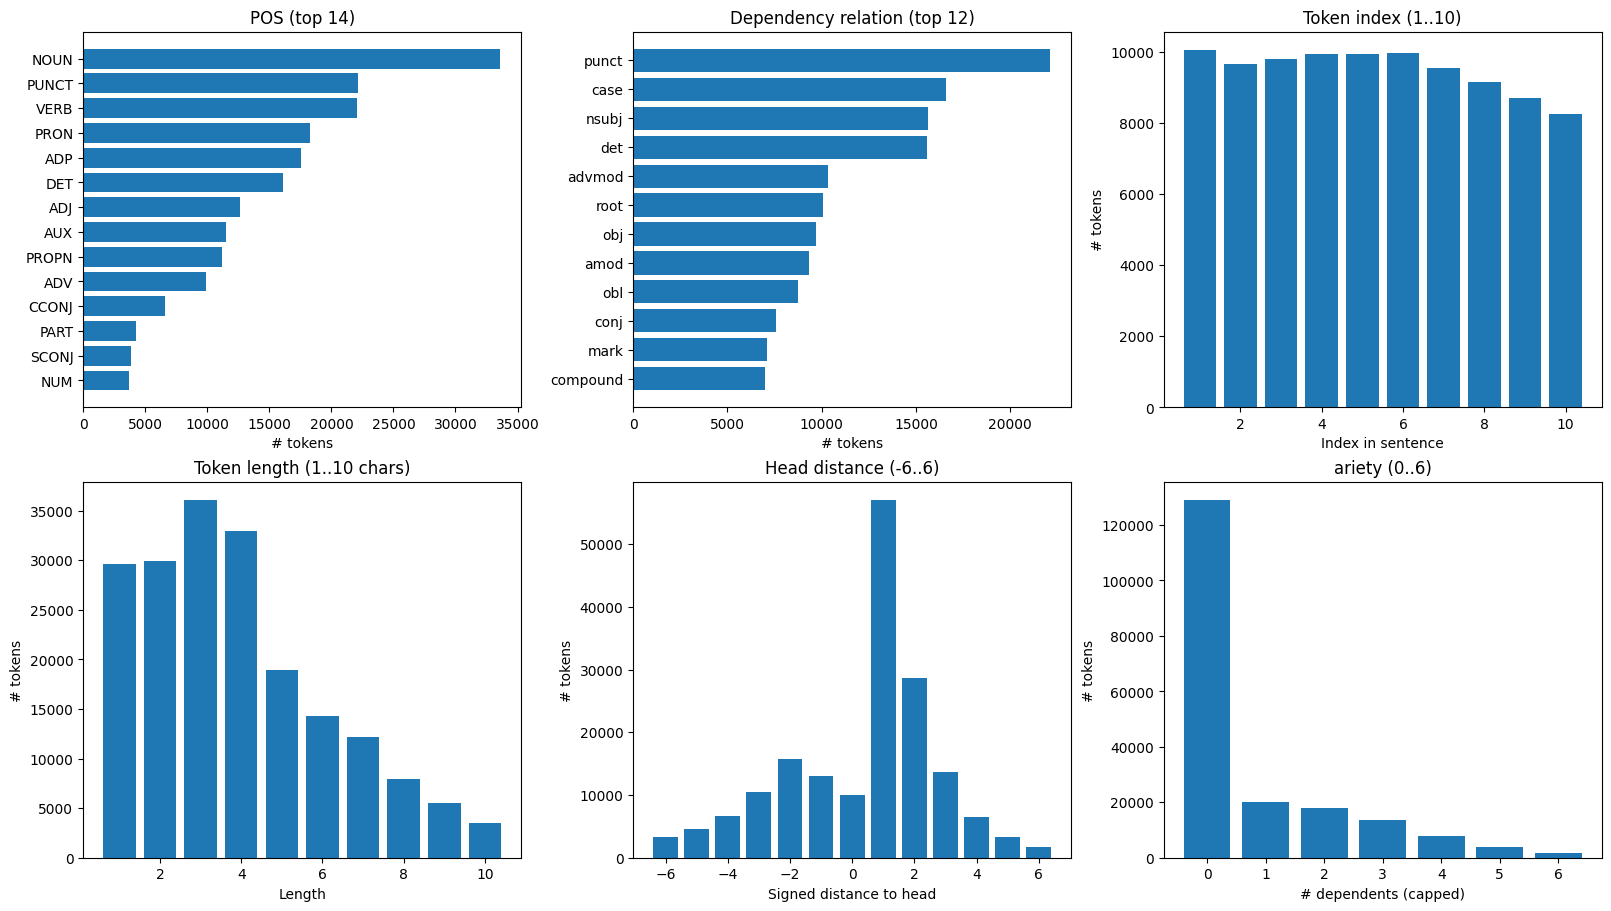

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9), constrained_layout=True)
ax_pos, ax_rel, ax_idx, ax_len, ax_hd, ax_ar = axes.flatten()

# POS 
ax_pos.barh(list(reversed(pos_counts.index.tolist())), list(reversed(pos_counts.values.tolist())))
ax_pos.set_title(f"POS (top {TOPK_POS})")
ax_pos.set_xlabel("# tokens")

# Relation types 
ax_rel.barh(list(reversed(rel_counts.index.tolist())), list(reversed(rel_counts.values.tolist())))
ax_rel.set_title(f"Dependency relation (top {TOPK_REL})")
ax_rel.set_xlabel("# tokens")

# Index
ax_idx.bar(index_counts.index.astype(int), index_counts.values)
ax_idx.set_title(f"Token index (1..{MAX_INDEX})")
ax_idx.set_xlabel("Index in sentence")
ax_idx.set_ylabel("# tokens")

# Length
ax_len.bar(length_counts.index.astype(int), length_counts.values)
ax_len.set_title(f"Token length (1..{MAX_LENGTH} chars)")
ax_len.set_xlabel("Length")
ax_len.set_ylabel("# tokens")

# Head distance
if head_dist_counts is None:
    ax_hd.text(0.5, 0.5, "No head_dist column found", ha="center", va="center")
    ax_hd.set_axis_off()
else:
    ax_hd.bar(head_dist_counts.index.astype(int), head_dist_counts.values)
    ax_hd.set_title(f"Head distance ({MIN_HEAD_DIST}..{MAX_HEAD_DIST})")
    ax_hd.set_xlabel("Signed distance to head")
    ax_hd.set_ylabel("# tokens")

# ariety
if ariety_counts is None:
    ax_ar.text(0.5, 0.5, "No ariety column found", ha="center", va="center")
    ax_ar.set_axis_off()
else:
    ax_ar.bar(ariety_counts.index.astype(int), ariety_counts.values)
    ax_ar.set_title(f"ariety (0..{MAX_ariety})")
    ax_ar.set_xlabel("# dependents (capped)")
    ax_ar.set_ylabel("# tokens")

plt.show()

if SAVE_FIG:
    FIG_PATH.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(FIG_PATH, dpi=200)
    print(f"✓ Saved figure to {FIG_PATH.resolve()}")
